In [25]:
using NBInclude
include("punto_fijo.jl")
include("forward_euler.jl")
include("backward_euler.jl")
include("rk4.jl")
include("modified_euler.jl")

modified_euler (generic function with 1 method)

## Punto 1

Considere la ecuación siguiente
$$f(x) = x^3 -3x + 1 = 0$$

A partir de la ecuación anterior, construya un sistema de orden 3 en la forma \(x=F(x)\). Aplique el método de aproximaciones sucesivas para encontrar una solución. Verifique las condiciones teóricas que permiten obtener una aproximación a una solución.

In [2]:
# Import necessary packages
using Printf

# Parameters
initial_guess = 1.0
tolerance = 1e-6
max_iterations = 1000


# Call the root-finding function
root, iterations = punto_fijo(initial_guess, tolerance, max_iterations)

# Output results
if root !== nothing
    @printf("Raíz aproximada: %.6f\n", root)
    @printf("Iteraciones necesarias: %d\n", iterations)
else
    println("El método no convergió después de alcanzar el número máximo de iteraciones.")
end


Raíz aproximada: 1.532089
Iteraciones necesarias: 17


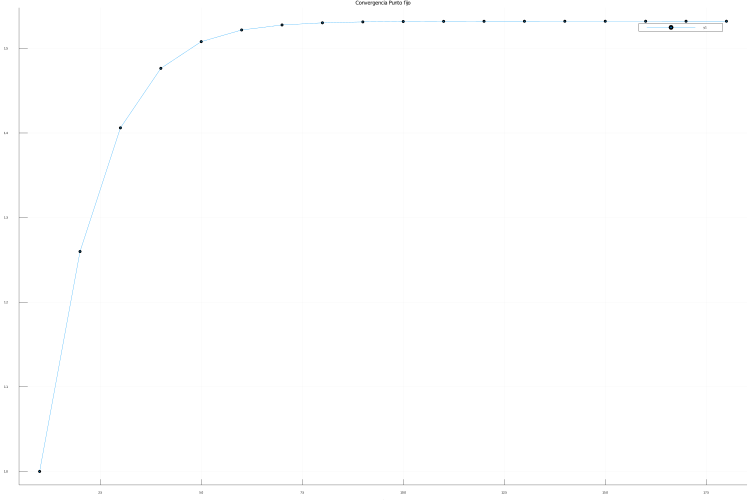

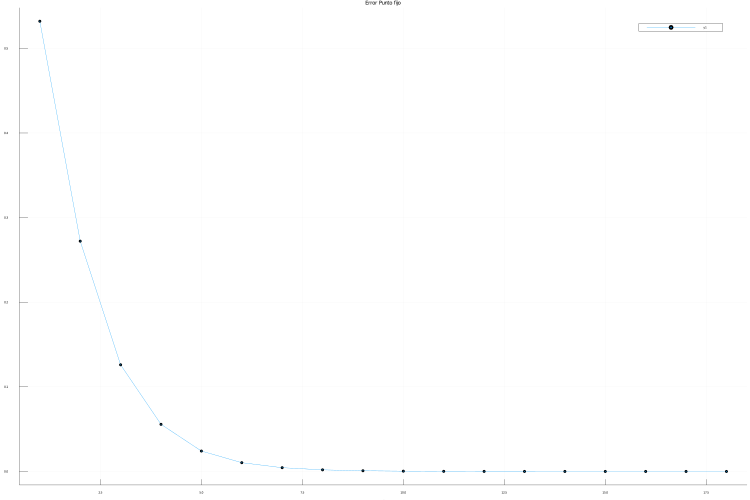

In [3]:
function punto_fijo2(x0, tol, nmax)
    x = zeros(Float64, nmax)
    x[1] = x0
    i = 2  # Initialize i here
    while i <= nmax
        x[i] = F(x[i-1])
        if abs(x[i] - x[i-1]) < tol
            break
        end
        i += 1  # Increment i
    end
    return x[1:i]
end



x_array = punto_fijo2(initial_guess, tolerance, max_iterations)

using Plots

# Set the default plot size
default(size = (3000, 2000))  # Adjust the values to your preference

# Plot the values of x
plot(x_array, marker = :o, xlabel = "Iteraciones", ylabel = "x", title = "Convergencia Punto fijo", grid = true)
display(plot!())  # Show the plot

# Plot the error
plot(abs.(x_array .- x_array[end]), marker = :o, xlabel = "Iteraciones", ylabel = "Error", title = "Error Punto fijo", grid = true)
display(plot!())  # Show the plot


Use el método de aproximaciones sucesivas para encontrar una solución cercana a $(x_1,x_2) = (1,1)$  del sistema siguiente:


\begin{cases}
2x_{1}^2 + x_{2}^2 &= 4.32 \\ 
x_{1}^2 - x_{2}^2 &= 0 
\end{cases}


Verifique las condiciones teóricas que permiten obtener una aproximación a una solución.

In [4]:
function F1(x2)
    return sqrt((4.32 - x2^2) / 2)
end

function F2(x1)
    return sqrt(x1^2)
end

function punto_fijo_system(x1, x2, tolerance, max_iterations)
    for i in 1:max_iterations
        x1_next = F1(x2)
        x2_next = F2(x1)
        if abs(x1_next - x1) < tolerance && abs(x2_next - x2) < tolerance
            return x1_next, x2_next, i
        end
        x1, x2 = x1_next, x2_next
    end
    return nothing, nothing, max_iterations
end

# Parameters
initial_x1 = 1.0
initial_x2 = 1.0
tolerance = 5e-6
max_iterations = 1000

# Call the punto_fijo_system function
x1_approx, x2_approx, iterations = punto_fijo_system(initial_x1, initial_x2, tolerance, max_iterations)

# Output results
if x1_approx !== nothing && x2_approx !== nothing
    @printf("Aproximación de x1: %.6f\n", x1_approx)
    @printf("Aproximación de x2: %.6f\n", x2_approx)
    @printf("Iteraciones necesarias: %d\n", iterations)
else
    println("El método no convergió después de alcanzar el número máximo de iteraciones.")
end

Aproximación de x1: 1.200001
Aproximación de x2: 1.199997
Iteraciones necesarias: 33


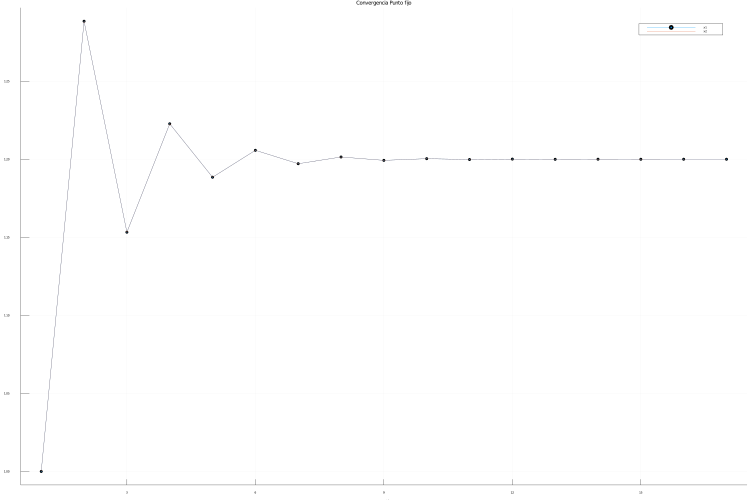

In [10]:
using Plots

function punto_fijo_system2(x1, x2, tolerance, max_iterations)
    x_values = Float64[x1]
    y_values = Float64[x2]
    iteration_counter = 0
    while true
        x1 = F1(x2)
        x2 = F2(x1)
        push!(x_values, x1)
        push!(y_values, x2)
        iteration_counter += 1
        if iteration_counter >= max_iterations
            println("No converge")
            break
        end
        if abs(x_values[end] - x_values[end-1]) < tolerance && abs(y_values[end] - y_values[end-1]) < tolerance
            break
        end
    end
    return x_values, y_values, iteration_counter
end

# Call the punto_fijo_system2 function
x_values, y_values, iteration_counter = punto_fijo_system2(1.0, 1.0, 1e-5, 100)

# Plot x and y
plot(x_values, marker = :o, label = "x1")
plot!(y_values, line = :solid, label = "x2")
plot!(grid = true)  # Enable the grid
xlabel!("Iteración")
ylabel!("Valor")
title!("Convergencia Punto fijo")


## Punto 2

Un oscilador amortiguado esta modelado por la ecuación diferencial

$$y'' + 10y' + 500y = 0$$

con condiciones iniciales:

$$y(0) = -0.025$$
$$y'(0) = -1$$

Esta ecuación tiene como solución exacta:

$$y(t) = e^{-5t} \left(-0.025 \cos(5 \sqrt{19} t) - 0.0516185 \sin(5 \sqrt{19} t)\right)$$




 Estimar $y(0.053)$ usando el método de Euler progresivo, Euler retrógrado y Euler modificado con $h=0.025$, y usar el método de Runge-Kutta de cuarto orden con $h=0.05$. Para ello, determine la solución exacta de la ecuación diferencial planteada y realice un cuadro comparativo (o curvas de error si es de su preferencia) entre los métodos implementados.

### Solución exacta

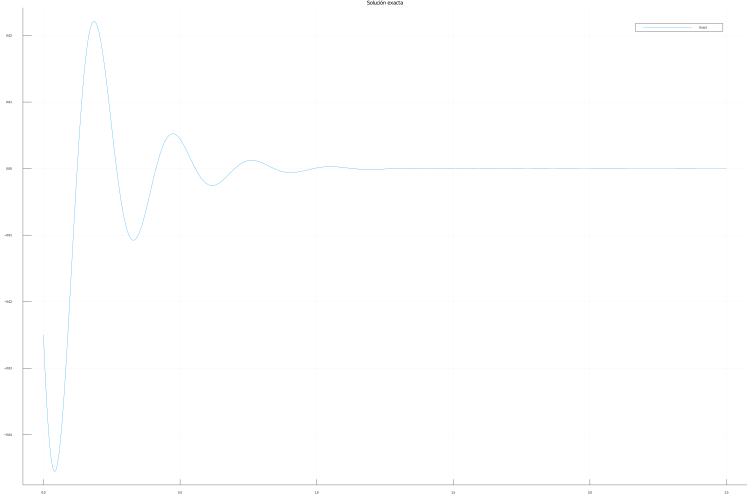

In [11]:
h = 0.025

time = range(0, stop = 2.5, length = 1000)

function y_analytic(t)
    return exp(-5*t) * (-0.025 * cos(5 * √19 * t) - 0.0516185 * sin(5 * √19 * t))
end

y = y_analytic.(time)

plot(time, y, label = "Exact", xlabel = "t", ylabel = "y", title = "Solución exacta", grid = true, legend = :topright)

### Solución Euler explícito - Euler hacia adelante

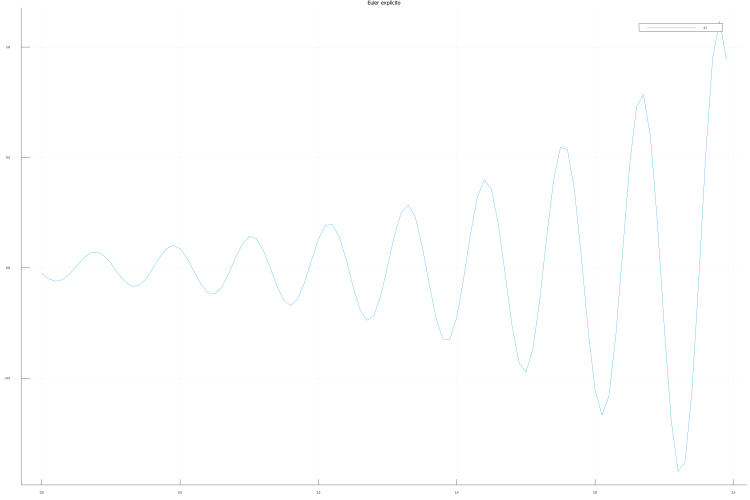

In [19]:
using LinearAlgebra  # For creating arrays


A = [0 1; -500 -10]
y0 = [-0.025, -1]

t = 0:0.025:2.475  # Note: adjusted the range to end at 2.475 for better alignment with forward Euler steps

function forward_euler(A, y0, t, h)
    y = zeros(length(y0), length(t))
    y[:, 1] = y0
    for i in 2:length(t)
        y[:, i] = y[:, i - 1] + h * A * y[:, i - 1]
    end
    return y
end

y_forward = forward_euler(A, y0, t, 0.025)

plot(t, y_forward[1, :], label = "y1", xlabel = "t", ylabel = "y", title = "Euler explícito", grid = true, legend = :topright)

### Solución Euler implícito - Euler hacia atrás

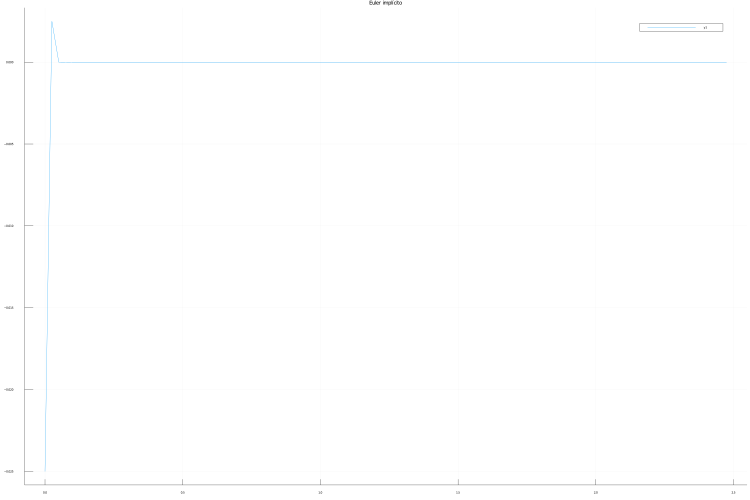

In [23]:
using LinearAlgebra
using Plots

A = [0 1; -500 -10]
y0 = [-0.025, -1]

t = 0:0.025:2.475

y_backward = backward_euler(A, y0, t, 0.025)

plot(t, y_backward[:, 1], label = "y1", xlabel = "t", ylabel = "y", title = "Euler implícito", grid = true, legend = :topright)


### Solución Euler modificado - Euler mejorado

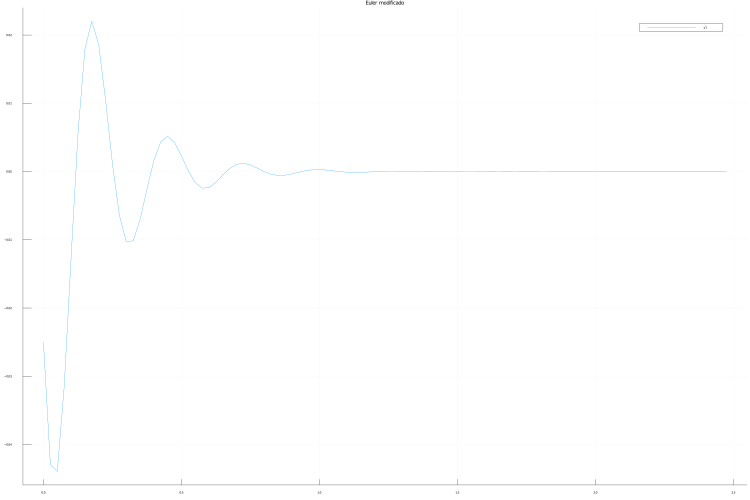

In [26]:
A = [0 1; -500 -10]
y0 = [-0.025, -1]

t = 0:0.025:2.475

y_modified = modified_euler(A, y0, t, 0.025)

plot(t, y_modified[:, 1], label = "y1", xlabel = "t", ylabel = "y", title = "Euler modificado", grid = true, legend = :topright)

### Solución con el método Runge-Kuta de orden 4

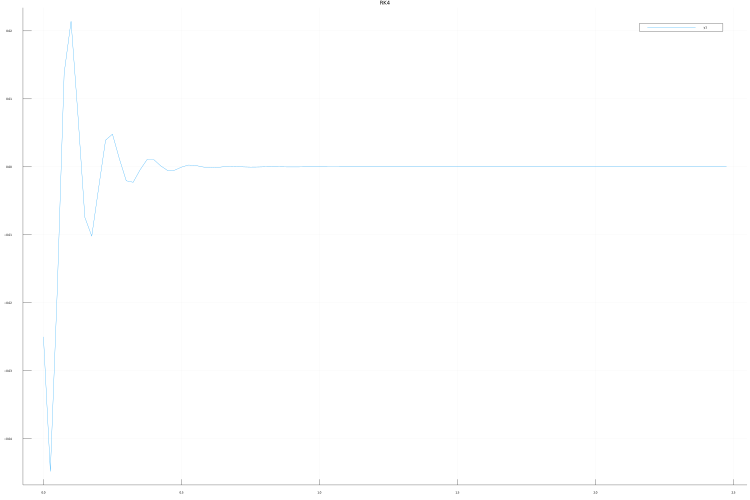

In [27]:
using LinearAlgebra
using Plots

A = [0 1; -500 -10]
y0 = [-0.025, -1]

h_rk = 0.05

t = 0:0.025:2.475

y_rk4 = rk4(A, y0, t, h_rk)

plot(t, y_rk4[:, 1], label = "y1", xlabel = "t", ylabel = "y", title = "RK4", grid = true, legend = :topright)


#### Solución en y(0.053)

### Curvas de error

### Exacta vs RK4

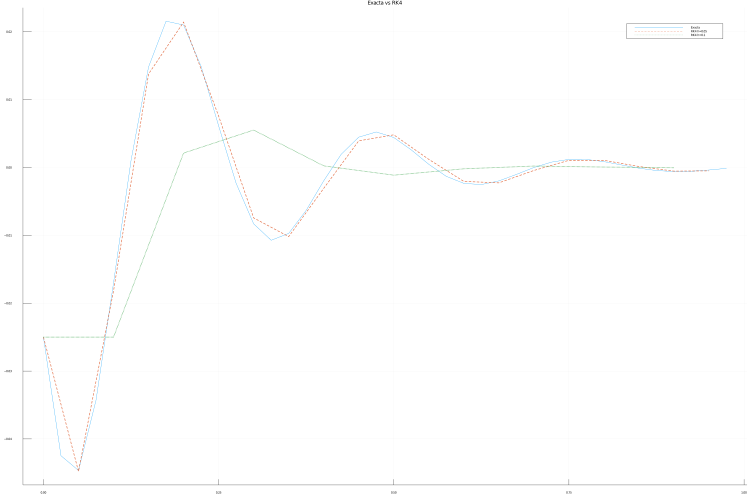

In [32]:
# Define constants
A = [0 1; -500 -10]
y0 = [-0.025, -1]
h_rk_1 = 0.05
h_rk_2 = 0.1

# Define time ranges
t = 0:0.025:0.975
t_rk1 = 0:h_rk_1:0.95
t_rk2 = 0:h_rk_2:0.9

# Perform calculations
y_exact = y_analytic.(t)
y_runge1 = rk4(A, y0, t_rk1, h_rk_1)
y_runge_2 = rk4(A, y0, t_rk2, h_rk_2)

# Plot the results
plot(t, y_exact, label = "Exacta")
plot!(t_rk1, y_runge1[:, 1], label = "RK4 h=0.05", linestyle = :dash, linewidth = 2.5)
plot!(t_rk2, y_runge_2[:, 1], label = "RK4 h=0.1", linestyle = :dot, linewidth = 3)
xlabel!("t")
ylabel!("y(t)")
title!("Exacta vs RK4")

### Gráfica de todas las soluciones

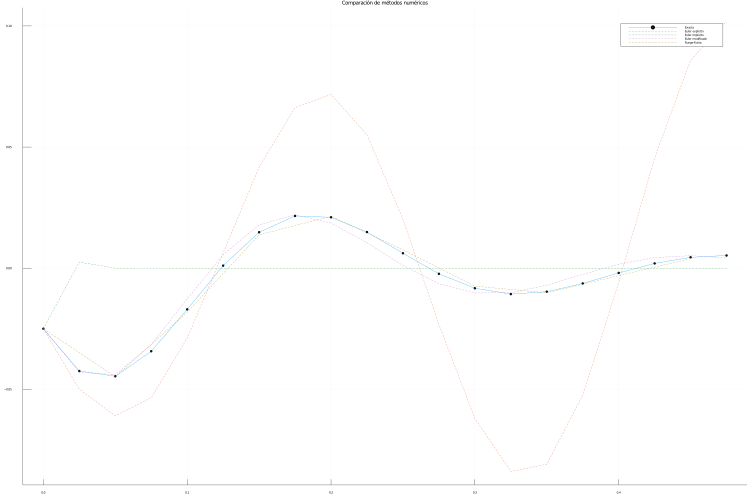

In [34]:
using LinearAlgebra
using Plots

# Define the functions and methods

# ... (previous function definitions)

# Define constants
A = [0 1; -500 -10]
y0 = [-0.025, -1]
h = 0.025
h_rk = 0.05

# Define time ranges
t = 0:0.025:0.475
t_rk = 0:0.05:0.45

# Perform calculations
y_exact = y_analytic.(t)
y_forward = forward_euler(A, y0, t, h)
y_backward = backward_euler(A, y0, t, h)
y_modified = modified_euler(A, y0, t, h)
y_rk = rk4(A, y0, t_rk, h_rk)

# Plot the results
plot(t, y_exact, label = "Exacta", marker = :circle, linestyle = :solid)
plot!(t, y_forward[1,: ], label = "Euler explícito", linestyle = :dash)
plot!(t, y_backward[:, 1], label = "Euler implícito", linestyle = :dash)
plot!(t, y_modified[:, 1], label = "Euler modificado", linestyle = :dash)
plot!(t_rk, y_rk[:, 1], label = "Runge-Kutta", linestyle = :dash)

# Beautify the plot
xlabel!("t")
ylabel!("y(t)")
title!("Comparación de métodos numéricos")